In [87]:
import sys 
sys.path.append('../../python/')

import os

import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
import statsmodels

import HNSCC_analysis_pipeline_lib as lib
%matplotlib notebook

# Environment

I can't seem to reporduce the error so it's probably a difference in package versions that we're using. Run the cell below and compare to mine (commented). 

In [88]:
print(pd.__version__) # 1.0.1
print(np.__version__) # 1.16.3 

1.0.1
1.16.3


# Define the data directory

We can do define the path `relative` to the current script directory, which is usually preferable as it's system independent. I was defining the `absolute` paths before because I had the `Trematinib-Combo-CI` folder outside of my github repo, now that they're combined we can simplify a bit. 

In [89]:
plate_map_dir = '../../plate_maps/'
data_dir = '../data/'

files = os.listdir(data_dir) # list the files in the ../data/ directory 
print('\n'.join(files)) # take a peak
print()

idx = 0
plate_data_path = data_dir + files[idx]   # change idx to choose a different file 
print('plate data path:', plate_data_path)

lab_id=10004-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx
lab_id=10250-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx
lab_id=10292-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx
lab_id=10326-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx
lab_id=10336-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx
lab_id=20003-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx

plate data path: ../data/lab_id=10004-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx


# Map the data

Looks like you figured this part out, nice job! We use the plate map to reorganize the data into a long format. Unfortunately, it can be a pain to debug someone elses code and I can't say that this is my prettiest code. 

In [90]:
p = lib.panel(plate_path=plate_data_path, platemap_dir = plate_map_dir, verbose=True, path_sep='\\')

path ../data/lab_id=10004-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx
---------------------------------------------------------
please double check file name parsing is accurate
file name: ../data/lab_id=10004-norm=blank490-plate_version_id=OHSU_HNSCC_derm004-note=Combo Plate.xlsx
lab_id: 10004
norm: blank490
version_id: OHSU_HNSCC_derm004
notes: Combo Plate
---------------------------------------------------------

--------------------------------------------------------------------------
This is the message log for: 
	lab_id: 10004
	version_id: OHSU_HNSCC_derm004
	notes: Combo Plate
--------------------------------------------------------------------------
Data has already been normalized by positive controls: True
This assay has 4 plates


In [91]:
p.map_data()

mapping data... [OHSU_HNSCC_derm004]
mapping complete. 
	 mapped data shape: (1536, 11)
	 column names: [['lab_id', 'norm_type', 'plate_num', 'plate_row', 'assay_version_id', 'note', 'plate_col', 'optical_density', 'conc', 'inhibitor', 'map_version_id']]


In [92]:
p.normalize_cell_viability_by_negative_controls()

normalizing cell viability by negative controls...
plate average controls: 
                PAC
plate_num          
1          0.435500
2          0.435333
3          0.395000
4          0.490000


In [93]:
p.set_floor()
p.set_ceiling()

Applying a ceiling of 1 to cell viability...


In [94]:
data = p.data
data.head()

,lab_id,norm_type,plate_num,plate_row,assay_version_id,note,plate_col,optical_density,conc,inhibitor,map_version_id,PAC,cell_viab,low_PAC_flag,is_adj
0,10004,Blank 490:490,1,A,OHSU_HNSCC_derm004,Combo Plate,1,-0.033,,,OHSU_HNSCC_derm004,0.4355,0.0,False,True
1,10004,Blank 490:490,1,B,OHSU_HNSCC_derm004,Combo Plate,1,-0.032,,,OHSU_HNSCC_derm004,0.4355,0.0,False,True
2,10004,Blank 490:490,1,C,OHSU_HNSCC_derm004,Combo Plate,1,-0.025,,,OHSU_HNSCC_derm004,0.4355,0.0,False,True
3,10004,Blank 490:490,1,D,OHSU_HNSCC_derm004,Combo Plate,1,-0.027,,,OHSU_HNSCC_derm004,0.4355,0.0,False,True
4,10004,Blank 490:490,1,E,OHSU_HNSCC_derm004,Combo Plate,1,-0.026,,,OHSU_HNSCC_derm004,0.4355,0.0,False,True


In [95]:
data2 = data[['lab_id', 'inhibitor', 'conc', 'cell_viab']]

# Examine Avaliable Inihibitors 

These should be (after renaming) all be capitolized. If they are not, that drug will need to be added to the `drug_rework.xlsx` page. 

In [96]:
single_agents = data2[~data2.inhibitor.str.contains(';')].inhibitor.unique()
comb_agents = data2[data2.inhibitor.str.contains(';')].inhibitor.unique()

print('number of inhibitors:', len(single_agents) + len(comb_agents))
print('number of single agents:', len(single_agents))
print('number of combination agents:', len(comb_agents))
print()
print('\n'.join(single_agents))
print()
print('\n'.join(comb_agents))

number of inhibitors: 50
number of single agents: 27
number of combination agents: 23


HESPERIDIN
NONE
AZD4547
TRAMETINIB
NVP-ADW742
GSK-690693
CRIZOTINIB
GEFITINIB
F-S-V
FULVESTRANT
MLN120B
IXABEPOLONE
I-BET762
NILOTINIB
GLESATINIB
BGB324
AXITINIB
SGX-523
GILTERITINIB
GDC-0032
RUXOLITINIB PHOSPHATE
AZ960
FEDRATINIB
LAPATINIB DITOSYLATE
THALIDOMIDE
STEVIOSIDE

HESPERIDIN;TRAMETINIB
AZD4547;TRAMETINIB
NVP-ADW742;TRAMETINIB
GSK-690693;TRAMETINIB
CRIZOTINIB;TRAMETINIB
GEFITINIB;TRAMETINIB
FULVESTRANT;TRAMETINIB
MLN120B;TRAMETINIB
IXABEPOLONE;TRAMETINIB
I-BET762;TRAMETINIB
NILOTINIB;TRAMETINIB
GLESATINIB;TRAMETINIB
BGB324;TRAMETINIB
AXITINIB;TRAMETINIB
SGX-523;TRAMETINIB
GILTERITINIB;TRAMETINIB
GDC-0032;TRAMETINIB
RUXOLITINIB;TRAMETINIB
AZ960;TRAMETINIB
FEDRATINIB;TRAMETINIB
LAPATINIB;TRAMETINIB
THALIDOMIDE;TRAMETINIB
STEVIOSIDE;TRAMETINIB


# Combination Index 

In [97]:
def plot_combination_index(A, B, data): 
    '''
    '''
    pass

def calculate_ICxx(x, model, ICxx=0.5): 
    '''
    '''
    x2 = np.linspace(min(x), 10, 1e5)
    yhat = model.predict(sm.add_constant(x2))
    for i,yy in enumerate(yhat): 
        if yy <= ICxx: return x2[i]
        
    print('No IC50 found, is this an inhibitor assay (monotonic decreasing?)')
    return 10

    
def fit_logistic(inhib, x, y, plot=True):
    '''
    x <array like> concentration, should be log10 normalized 
    y <array like> cell viability, must be between 0,1

    '''
    logit = sm.GLM(y, sm.add_constant(x), family=sm.families.Binomial()) 
    glm_res = logit.fit(disp=False)

    x2 = np.arange(-5, 5, 0.001)
    yhat = glm_res.predict(sm.add_constant(x2))
    
    IC50 = calculate_ICxx(x, glm_res)

    f, ax = plt.subplots(1,1, figsize=(7,7))
    plt.title('inhibitor: %s' %(inhib))
    plt.plot(x2, yhat, 'r-', label='logistic')
    plt.plot(x, y, 'bo', label='replicates')
    plt.axvline(IC50, color='g', label=f'IC50 [{10**IC50:.4f} (uM)]')
    plt.ylim((0,1.25))
    plt.legend()
    plt.show()

    # beta0 = intercept
    # beta1 = slope
    intercept,beta1 = glm_res.params
    probit_AIC, probit_BIC = glm_res.aic, glm_res.bic
    probit_Deviance = glm_res.deviance
    probit_pval = glm_res.pvalues

    print(glm_res.summary())
    
    return IC50

### Hesperidin : Trametinib 

minimum CI value [0.80] found at: Hesperidin=[0.14791084], Trametinib=[0.01412538]]  
This combination is synergistic between: Hesperidin:[0.015-0.603], Trametinib:[0.011-0.020]  

### NVP-ADW742 : Trametinib

minimum CI value [0.96] found at: NVP-ADW742=[6.02559586], Trametinib=[0.01949845]]  
This combination is synergistic between: NVP-ADW742:[2.630-8.710], Trametinib:[0.019-0.020]  

### GSK-690693 : Trametinib 

minimum CI value [0.39] found at: GSK-690693=[0.57543994], Trametinib=[0.00616595]]  
This combination is synergistic between: GSK-690693:[0.013-5.495], Trametinib:[0.003-0.020]  

### Crizotinib : Trametinib

minimum CI value [0.82] found at: Crizotinib=[0.00102329], Trametinib=[0.01659587]]  
This combination is synergistic between: Crizotinib:[0.001-0.708], Trametinib:[0.017-0.020]  
  
### Gefitinib : Trametinib

minimum CI value [0.33] found at: Gefitinib=[0.05623413], Trametinib=[0.00288403]]  
This combination is synergistic between: Gefitinib:[0.013-0.295], Trametinib:[0.000-0.019]  

In [98]:
### Good Examples
# AZ960 - Trametinib 

drugA = 'GSK-690693'
drugB = 'TRAMETINIB'

#plot_combination_index(drugA, drugB, data2)

dataA = data2[data2.inhibitor == drugA]
dataB = data2[data2.inhibitor == drugB]
dataAB = data2[data2.inhibitor == ';'.join([drugA, drugB])]

print('dataframe shapes')
print('\tA:', dataA.shape)
print('\tB:', dataB.shape)
print('\tAB:',dataAB.shape)

dataframe shapes
	A: (6, 4)
	B: (144, 4)
	AB: (36, 4)


C:\anaconda-3.5.2.0\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


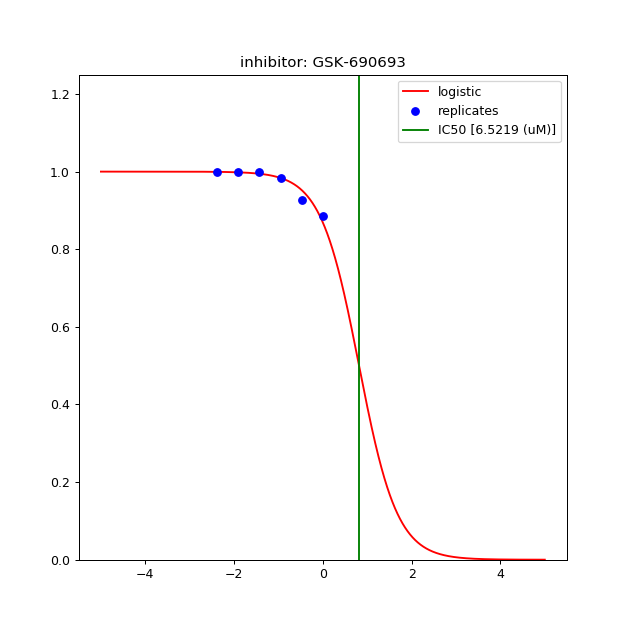

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    6
Model:                            GLM   Df Residuals:                        4
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:               -0.53325
Date:                Mon, 20 Apr 2020   Deviance:                     0.030316
Time:                        11:31:55   Pearson chi2:                   0.0241
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8884      2.774      0.681      0.496      -3.548       7.325
x1            -2.3190      5.539     -0.419      0.6

In [99]:
x = np.log10(dataA.conc.values.astype(np.float))
y = dataA.cell_viab.values

IC50A = fit_logistic(drugA, x, y, plot=True)

C:\anaconda-3.5.2.0\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


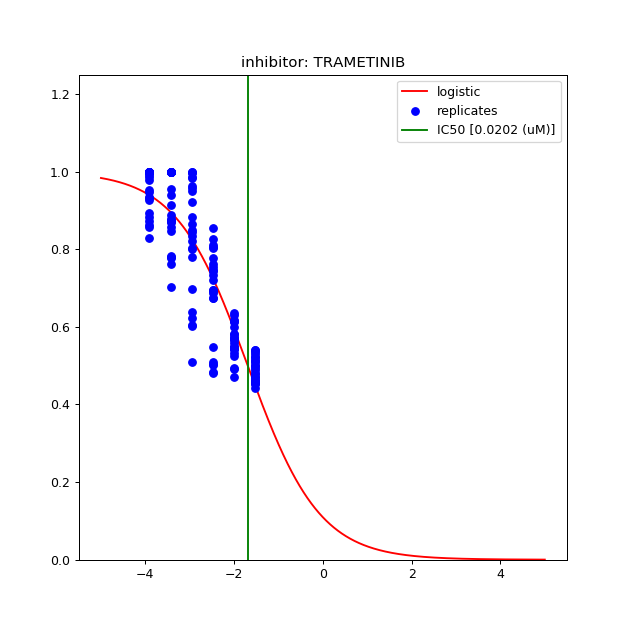

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  144
Model:                            GLM   Df Residuals:                      142
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49.599
Date:                Mon, 20 Apr 2020   Deviance:                       10.848
Time:                        11:31:55   Pearson chi2:                     9.42
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0978      0.712     -2.948      0.003      -3.493      -0.703
x1            -1.2384      0.288     -4.296      0.0

In [100]:
x = np.log10(dataB.conc.values.astype(np.float))
y = dataB.cell_viab.values

IC50B = fit_logistic(drugB, x, y, plot=True)

# Combination Agent 

In [64]:
x = dataAB.conc.values
Z = dataAB.cell_viab.values

A=[]; B=[]
for xx in x: 
    A.append( float(xx.split(';')[0]) )
    B.append( float(xx.split(';')[1]) )
    
A = np.log10( np.array(A) )
B = np.log10( np.array(B) )

#print(A,B)

In [101]:
endog = dataAB.cell_viab.values
exog = sm.add_constant( np.concatenate((A.reshape(-1,1),B.reshape(-1,1)), axis=1) )

Z shape: (36,)


<IPython.core.display.Javascript object>


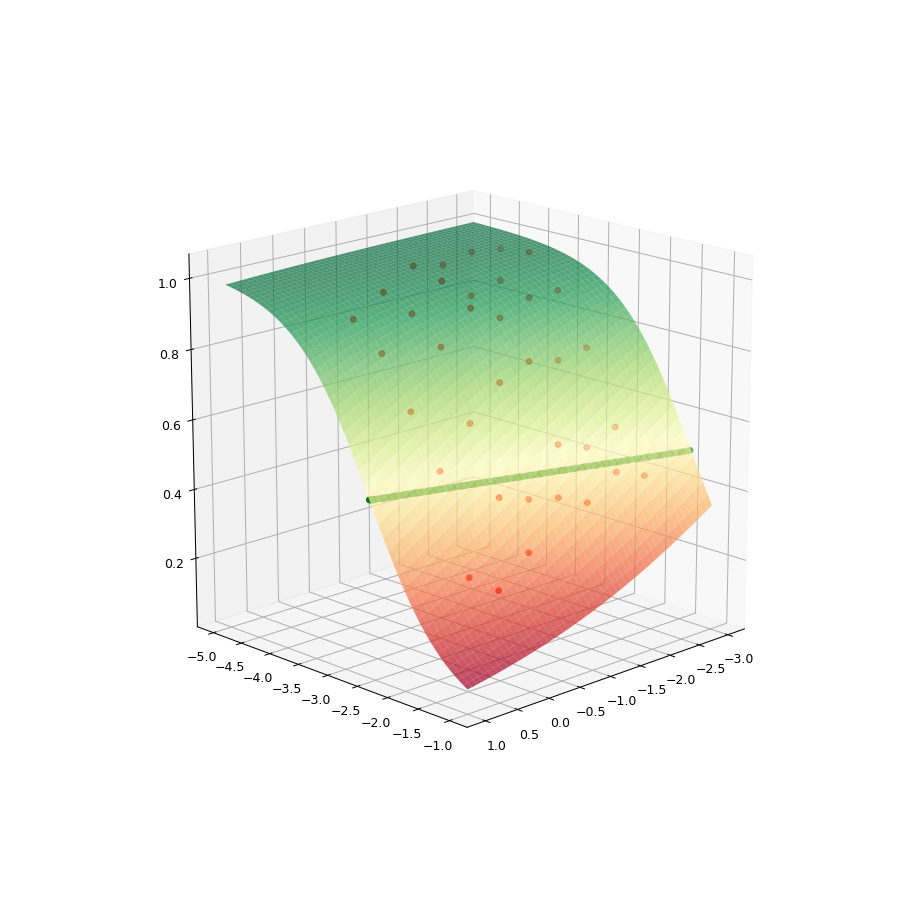

In [102]:
logit = sm.GLM(endog, exog, family=sm.families.Binomial()) 
res = logit.fit(disp=False)

X = np.arange(-3, 1, 0.01)
Y = np.arange(-5, -1, 0.01)
X, Y = np.meshgrid(X, Y)

IC50s = {'x':[], 'y':[], 'z':[]} 
Zmat = [] 
for xx, yy in zip(X, Y): 
    exog2 = sm.add_constant( np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)), axis=1), has_constant='add') 
    yyhat = res.predict( exog2 )
    Zmat.append( yyhat )
    
    for xxx,yyy in zip(xx, yy): 
        yyyhat = res.predict( np.array([1,xxx,yyy]) )[0]
        if np.isclose(yyyhat, 0.5, atol=0.001, rtol=0): 
            IC50s['x'].append(xxx)
            IC50s['y'].append(yyy)
            IC50s['z'].append(yyyhat)
        
    
Zmat = np.array( Zmat ) 
print ('Z shape:', Z.shape)

# Plot the surface.
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(A,B,Z, c='r')
ax.plot_surface(X, Y, Zmat, alpha=0.7, cmap='RdYlGn')
ax.scatter(IC50s['x'], IC50s['y'], IC50s['z'], c='g')

plt.show()

drugA (GSK-690693) IC50: 6.5218523582789185 (uM))
drugB (GSK-690693) IC50: 0.020232339837789777 (uM)
      x     y         z
0  0.99 -2.59  0.500976
1  0.96 -2.58  0.500670
2  0.97 -2.58  0.499379
3  0.93 -2.57  0.500365
4  0.94 -2.57  0.499074


<IPython.core.display.Javascript object>


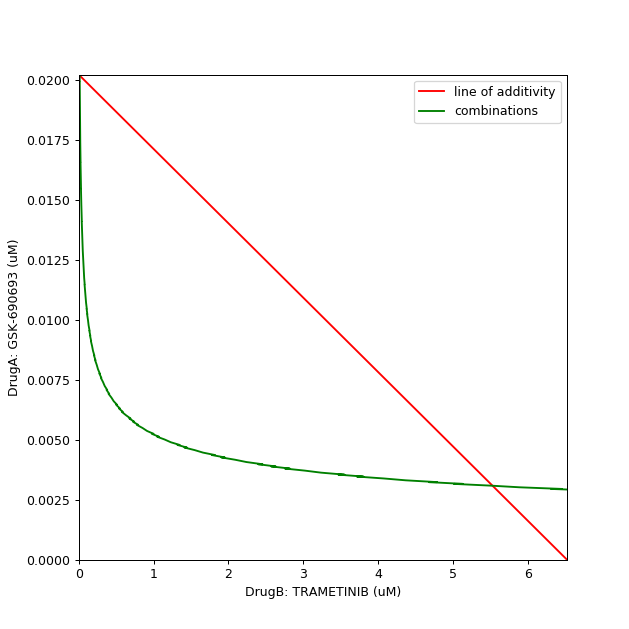

0.8143709630209144


In [103]:
print(f'drugA ({drugA}) IC50: {10**IC50A} (uM))')
print(f'drugB ({drugA}) IC50: {10**IC50B} (uM)')


comb = pd.DataFrame(IC50s).drop_duplicates()
print(comb.head())
plt.figure(figsize=(7,7)) 

print( IC50A ) 

x = [10**IC50A,0]
y = [0, 10**IC50B]


plt.plot(x,y, 'r', label='line of additivity')
plt.plot(10**comb.x.values, 10**comb.y.values, 'g-', label='combinations')

plt.xlim(x[::-1])
plt.ylim(y)
plt.xlabel(f'DrugB: {drugB} (uM)')
plt.ylabel(f'DrugA: {drugA} (uM)')
plt.legend()

plt.show() 

minimum CI value [0.39] found at: GSK-690693=[0.57543994], TRAMETINIB=[0.00616595]]
This combination is synergistic between: GSK-690693:[0.013-5.495], TRAMETINIB:[0.003-0.020]


<IPython.core.display.Javascript object>


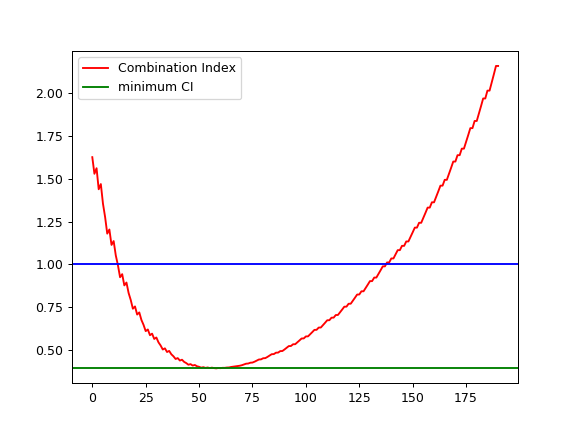

In [104]:
C_a = 10**np.array( IC50s['x'] )
C_b = 10**np.array( IC50s['y'] )

CI = C_a/10**IC50A + C_b/10**IC50B

idx = np.where(CI == min(CI))
Ca_min = C_a[idx]
Cb_min = C_b[idx]

print(f'minimum CI value [{min(CI):.2f}] found at: {drugA}={Ca_min}, {drugB}={Cb_min}]')

idx2 = np.where(CI < 1)
Ca_range = C_a[idx2]
Cb_range = C_b[idx2]

print(f'This combination is synergistic between: {drugA}:[{min(Ca_range):.3f}-{max(Ca_range):.3f}], {drugB}:[{min(Cb_range):.3f}-{max(Cb_range):.3f}]')

plt.figure()
plt.plot(CI, 'r', label='Combination Index')
plt.axhline(min(CI), c='g', label='minimum CI')
plt.axhline(1, c='b')

plt.legend()
plt.show()